<a href="https://colab.research.google.com/github/taemin2100/bigdata_project/blob/main/bigdata2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리 불러오기

In [69]:
import pandas as pd
import numpy as np
import requests

내가 분석하고 싶은 동네 입력하기

In [70]:
target_name = "안산시단원구 초지동"

가게데이터 파일과 연령2데이터 파일을 블러온다
str[:8] 을 해준이유는 내가 가저온 데이터 파일에는 행정정동 코드가 8자리인데
geojson url에는 뒤에 00추가로 있다. 가져온 데이터 길이는 8 url 데이터 길이는 10이여서 길이를 맞추기 위해 사용


In [88]:
shop = pd.read_csv('/content/가게.csv', encoding='EUC-KR')
shop['행정동코드'] = shop['행정동코드'].astype(str).str[:8]

age = pd.read_excel('/content/연령2.xlsx')
age['행정동코드'] = age['행정동코드'].astype(str).str[:8]


연령 데이터에서 ID 역할을 하는 컬럼들('행정동코드', '행정동명', '시군구명')을 제외하고,나머지 숫자형 컬럼들을 연령대 관련 컬럼(age_cols)로 사용한다.

각 행(행정동)별로 연령대 인구수를 모두 더한 후, 각 연령대 값을 해당 합으로 나누어 연령 비율(age_ratio)을 계산한다.

In [92]:
id_cols = ['행정동코드', '행정동명', '시군구명']
age_cols = [c for c in age.columns if (c not in id_cols) and (age[c].dtype != 'O')]

age_vec = age[age_cols].astype(float)
row_sums = age_vec.sum(axis=1).replace(0, np.nan)
age_ratio = age_vec.div(row_sums, axis=0).fillna(0.0)
age_ratio['행정동코드'] = age['행정동코드']

age_map = {}
for _, row in age_ratio.iterrows():
    age_map[row['행정동코드']] = row[age_cols].to_numpy()


GitHub에 있는 경기도 행정동 경계 GeoJSON 파일을 requests.get()으로 불러온다.

GeoJSON url에는 {"type": "FeatureCollection", "name": "temp", "crs": {"type": "name", "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}}, "features": [{"type": "Feature", "properties": {"OBJECTID": 1156, "adm_nm": "\uacbd\uae30\ub3c4 \uc218\uc6d0\uc2dc\uc7a5\uc548\uad6c \ud30c\uc7a5\ub3d9", "adm_cd": "3101154", "adm_cd2": "4111156000", "sgg": "41111", "sido": "41", "sidonm": "\uacbd\uae30\ub3c4", "sggnm": "\uc218\uc6d0\uc2dc\uc7a5\uc548\uad6c"}
행정동코드,행정동이름 위도 경도등이 있다.



In [82]:
url = "https://raw.githubusercontent.com/raqoon886/Local_HangJeongDong/master/hangjeongdong_%EA%B2%BD%EA%B8%B0%EB%8F%84.geojson"
g_geo = requests.get(url).json()

'adm_nm' 안에 'target_name'(예: "안산시단원구 초지동")이 포함된 Feature를 찾아서  
  그 Feature의 코드 앞 8자리('adm_cd2[:8]')를 **target_code**로 저장한다.
 이렇게 하면 연령 데이터(age_map)와 GeoJSON을 같은 코드 체계(8자리)로 연결할 수 있다.

In [83]:
target_code = None
for f in g_geo['features']:
    name = f['properties']['adm_nm']
    code8 = f['properties']['adm_cd2'][:8]
    if target_name in name:
        target_code = code8
        break


- base_vec : 타겟 동(target_code)의 연령 비율 벡터. age_map에 들어 있는 모든 동에 대해, np.abs(vec - base_vec).sum() 으로 절대차이의 합을 계산한다.
- 차이가 작을수록 연령 구조가 비슷한 동이다.
- 모든 동에 대한 차이 리스트에서 최대값(max_diff)을 이용해  
  sim = 1 - diff / max_diff 로 0~1 사이의 유사도(similarity) 점수를 만든다.
- code_to_sim 딕셔너리에는 키 = 행정동코드(8자리) / 값 = 연령 유사도(0~1) 가 저장된다.
- 그 중에서 유사도 0.9 이상이고 타겟 동이 아닌 코드들만 골라서 similar_codes 리스트로 만든다.
- 이 동들이 우리 동과 연령대 분포가 비슷한 동들이다.

In [84]:
base_vec = age_map[target_code]

diffs = []
codes = []
for code, vec in age_map.items():
    diff = np.abs(vec - base_vec).sum()
    diffs.append(diff)
    codes.append(code)

max_diff = max(diffs) if max(diffs) > 0 else 1.0

code_to_sim = {}
for code, diff in zip(codes, diffs):
    sim = 1 - diff / max_diff
    code_to_sim[code] = sim

similar_codes = [c for c, s in code_to_sim.items() if (s >= 0.9) and (c != target_code)]



- similar_shops : 연령 구조가 비슷한 동들(similar_codes)에 속한 점포들만 모은 데이터.
- my_shops : 우리 동네(target_code)에 해당하는 점포들만 모은 데이터.두 그룹에서 상권업종중분류명 기준으로 업종 비율을 구한다.
- value_counts(normalize=True) 를 사용하여 업종 비율(%)을 계산한다.
- 두 그룹에 등장하는 모든 업종 집합을 all_types로 만든 뒤,각 업종마다 우리 동네 비율 (my_ratio * 100) 유사 동 평균 비율 (sim_ratio * 100) 둘의 차이 (우리동네 - 유사동, % 단위) 를 구해서 표로 만든다.
- 차이(우리동네-유사동)(%) 기준으로 오름차순 정렬하여, 값이 작은 업종부터 보면 우리 동네에 상대적으로 부족한 업종을 알 수 있다.
- 그 중 상위 10개를 top10으로 출력한다.


In [85]:
similar_shops = shop[shop['행정동코드'].isin(similar_codes)]
my_shops = shop[shop['행정동코드'] == target_code]

similar_type_ratio = similar_shops['상권업종중분류명'].value_counts(normalize=True)
my_type_ratio = my_shops['상권업종중분류명'].value_counts(normalize=True)

all_types = set(similar_type_ratio.index) | set(my_type_ratio.index)

rows = []
for t in all_types:
    my_ratio = my_type_ratio.get(t, 0.0)
    sim_ratio = similar_type_ratio.get(t, 0.0)
    rows.append([
        t,
        my_ratio * 100,
        sim_ratio * 100,
        (my_ratio - sim_ratio) * 100
    ])

result = pd.DataFrame(rows, columns=[
    '업종(상권업종중분류명)',
    '우리동네_비율(%)',
    '유사동_평균비율(%)',
    '차이(우리동네-유사동)(%)'
])

result = result.sort_values('차이(우리동네-유사동)(%)')

top10 = result.head(10)

print("연령대 유사도 0.9 이상 동 개수:", len(similar_codes))
print(f"우리 동네({target_name}) 점포 수:", len(my_shops))
print("연령대 유사 동 그룹 점포 수:", len(similar_shops))
print("\n===== 연령대 비율이 비슷한 동 기준, 우리 동네에서 상대적으로 부족한 업종 TOP 10 (%) =====")
print(top10)


연령대 유사도 0.9 이상 동 개수: 15
우리 동네(안산시단원구 초지동) 점포 수: 3069
연령대 유사 동 그룹 점포 수: 17375

===== 연령대 비율이 비슷한 동 기준, 우리 동네에서 상대적으로 부족한 업종 TOP 10 (%) =====
   업종(상권업종중분류명)  우리동네_비율(%)  유사동_평균비율(%)  차이(우리동네-유사동)(%)
51        이용·미용    3.551645     7.200000        -3.648355
17        일반 교육    2.378625     4.920863        -2.542238
69  섬유·의복·신발 소매    2.411209     4.920863        -2.509654
10        기타 교육    3.095471     5.438849        -2.343378
28        기타 간이    3.649397     5.732374        -2.082977
71           의원    1.466276     3.056115        -1.589839
72           주점    2.052786     3.234532        -1.181746
42       유원지·오락    1.335940     2.486331        -1.150391
22    의약·화장품 소매    1.564027     2.330935        -0.766908
58       식료품 소매    2.150538     2.808633        -0.658095


시각화를 위해 folium 라이브러리를 불러온다.
- 내가 지정한 동네는 가장 빨강색으로 지정
- 내가 지정한 동네와 유사도가 0.9이상인 동네는 연한 빨강색으로 지정
- 나머지 동네는 노랑색으로 지정

In [96]:
import folium

center_lat = shop['위도'].mean()
center_lng = shop['경도'].mean()

g_map = folium.Map(location=[center_lat, center_lng], zoom_start=10)

def style_fn(feature):
    # GeoJSON 코드(10자리)를 앞 8자리만 사용
    code8 = feature['properties']['adm_cd2'][:8]
    sim = code_to_sim.get(code8, 0)

    # 타겟 동: 진한 빨강
    if code8 == target_code:
        return {
            "fillColor": "#ff0000",
            "color": "#990000",
            "weight": 3,
            "fillOpacity": 0.9
        }

    # 유사동 (0.9 이상): 빨강
    if sim >= 0.9:
        return {
            "fillColor": "#ff6666",
            "color": "#cc0000",
            "weight": 1,
            "fillOpacity": 0.7
        }

    # 나머지 동: 노란색
    return {
        "fillColor": "#ffff66",
        "color": "#bbbb00",
        "weight": 1,
        "fillOpacity": 0.5
    }

folium.GeoJson(
    g_geo,
    style_function=style_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=['adm_nm'],
        aliases=['행정동명']
    )
).add_to(g_map)

g_map



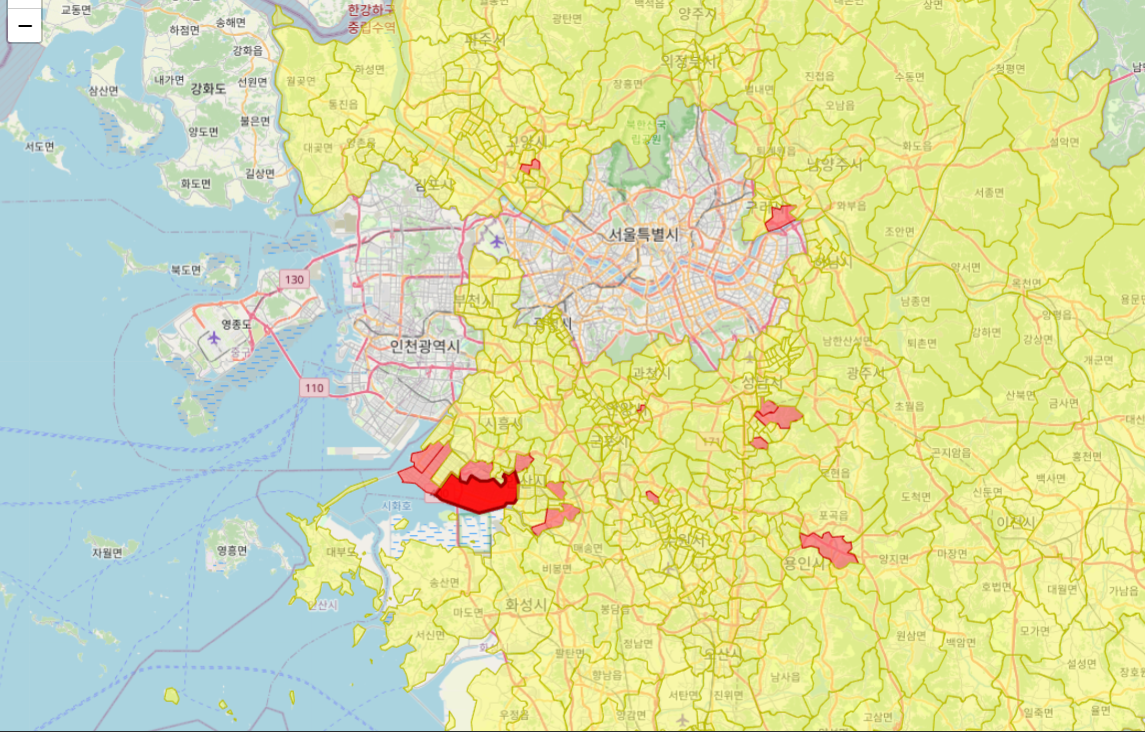

 그래프에 한글이 지원 되지 않아서 plotly.graph_objects as go룰 사용했습니다


In [ ]:
import plotly.graph_objects as go

부족한 업종 TOP 10 추출

In [90]:
topN = 10

plot_df = result.sort_values("차이(우리동네-유사동)(%)").head(topN).reset_index(drop=True)

fig = go.Figure()

fig.add_trace(go.Bar(
    y=plot_df["업종(상권업종중분류명)"],
    x=plot_df["차이(우리동네-유사동)(%)"],
    orientation="h",
    name="부족 정도(%)"
))

fig.update_layout(
    title=f"{target_name} 부족한 정도만 비교 (차이 기준 TOP {topN})",
    xaxis_title="우리동네 - 유사동 평균 (%)",
    yaxis_title="업종"
)

fig.update_yaxes(autorange="reversed")

fig.show()

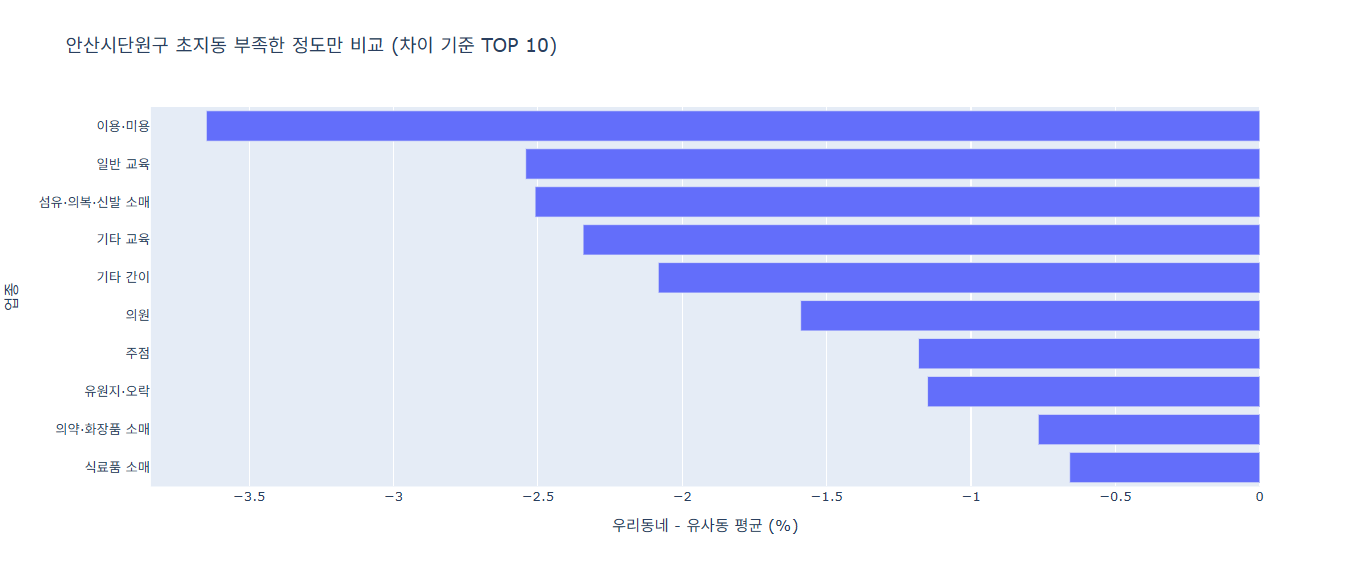